In [1]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import cdist
from multiprocessing import Pool
import multiprocessing as mp
import matplotlib.pyplot as plt
from figurefirst import mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable 

In [2]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)


def find_streakline(df, dt):
    eastwest = [np.sum(df.windx[j:]) * dt for j in range(0, len(df))]
    northsouth = [np.sum(df.windy[j:]) * dt for j in range(0, len(df))]
    return eastwest, northsouth

def get_gps_pos_vector(i, df):
    gps_vector=[(0-df.x[i]),(0-df.y[i])]
    return gps_vector

def get_st_pos_vector(streakline,pos,i):
    x = np.mean(streakline[pos:(pos+10),0])
    y = np.mean(streakline[pos:(pos+10),1])
    st = [(0-x),(0-y)]
    return st


def compute_ysign_encounter(streakline,pos, odor_position):
    if (streakline[pos,1]>odor_position[0][1]):
        # y_sign.append(-1)
        return -1
    else:
        # y_sign.append(1)
        return 1
        
def compute_xsign_encounter(streakline, pos, i,df):
    u = get_gps_pos_vector(i, df)
    v = get_st_pos_vector(streakline,pos,i)
    
    s = np.sign((np.dot(u,v)))
    if s == 0:
        s = 1
    return s
    # x_sign.append(s)
    
def compute_distance(streakline, odor_position, i, nearest_from_streakline,x_sign,y_sign, df):
    source = np.array([[0,0]])
    streakline = np.concatenate((streakline, source))
    distance = cdist(odor_position, streakline).flatten()
    nearest_from_streakline.append(np.min(distance))
    pos = np.where(distance == np.amin(distance))
    y_sign.append(compute_ysign_encounter(streakline, pos[0][0], odor_position))
    x_sign.append(compute_xsign_encounter(streakline,pos[0][0],i,df))


def process_file(folder_path,filename):
    y_sign=[]
    x_sign=[]
    nearest_from_streakline = []
    
    new_df=pd.DataFrame()
    df = pd.read_hdf(folder_path + filename)
    
    source = np.array([[0,0]])
    odor_position = np.array([[df.x[i], df.y[i]] for i in range(len(df))])
    distance_from_source = np.array([cdist(odor_position, source)]).flatten()
    # new_df['distance_from_source'] = distance_from_source

    dt = 0.3
    eastwest, northsouth = find_streakline(df, dt)
    

    for i in range(len(eastwest) - 1, 0, -1):
        odor_pos = [odor_position[i]]
        eastwest = np.resize(np.array([eastwest - df.windx[i] * dt]), (1, i)).flatten()
        northsouth = np.resize(np.array([northsouth - df.windy[i] * dt]), (1, i)).flatten()
        wind_pos = np.vstack([eastwest, northsouth]).T
        compute_distance(wind_pos, odor_pos, i, nearest_from_streakline,x_sign,y_sign, df)
        
    
    nearest_from_streakline.append(0.1)
    y_sign.append(1)
    x_sign.append(1)    
    
    df['nearest_from_streakline'] = nearest_from_streakline[::-1]
    

    squared_difference = np.square(distance_from_source) - np.square(df.nearest_from_streakline)
    squared_difference = np.abs(squared_difference)
    new_df['distance_along_streakline'] = np.sqrt(squared_difference) *  x_sign[::-1]
    new_df['nearest_from_streakline'] = df.nearest_from_streakline * y_sign[::-1]
    # new_df['distance_along_streakline'] = np.sqrt(squared_difference)
    # new_df['nearest_from_streakline'] = df.nearest_from_streakline 
    new_df['odor']=scale_data(df.odor)
    # new_df['windx']=df.windx
    # new_df['windy']=df.windy
    # new_df['x']=df.x
    # new_df['y']=df.ybackup
    
    new_df = new_df.iloc[100:]
    new_df.reset_index(drop=True, inplace=True)
    # return new_df
    # fp='/home/beast/An/data/train_new_axis_unscaled/'
    fp='/home/beast/An/data/Sept13Plumes/plume1/train_new/'
    # fp='/home/beast/An/data/Nov6/train/'
    new_df.to_hdf(fp + filename, key='data', mode='w')


In [3]:

def main():
    folder_path = '/home/beast/An/data/Sept13Plumes/plume1/train_raw_new/'
    # folder_path = '/home/beast/An/data/Nov6/encounters_raw/'
    all_filenames = [filename for filename in os.listdir(folder_path) if filename.startswith("diag") and filename.endswith(".h5")]
    sorted_filenames = sorted(all_filenames, key=lambda x: int(x[4:-3]))
    pool = Pool(mp.cpu_count()-1)
    pool.starmap(process_file, [(folder_path, filename) for filename in sorted_filenames])

if __name__ == "__main__":
    main()


In [25]:
# folder_path = '/home/beast/An/data/Sept13Plumes/plume2/train_raw/'
# all_filenames = [filename for filename in os.listdir(folder_path) if filename.startswith("diag") and filename.endswith(".h5")]
# sorted_filenames = sorted(all_filenames, key=lambda x: int(x[4:-3]))
# for filename in sorted_filenames:
#     process_file(folder_path, filename)


In [23]:
# fp='/home/beast/An/data/Sept13Plumes/plume3/train/'
fp='/home/beast/An/data/Nov6/train/'
filename='diag104.h5'
df = pd.read_hdf(fp+filename)
# df = process_file(fp, filename)

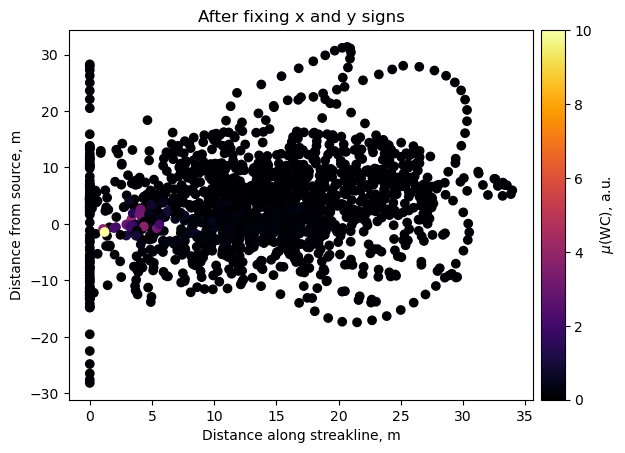

In [24]:
f, ax=plt.subplots(1,1)
v = ax.scatter(df.distance_along_streakline, df.nearest_from_streakline, c=scale_data(df.odor), cmap='inferno')

ax.set_title('After fixing x and y signs')
ax.set_ylabel('Distance from source, m')
ax.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')


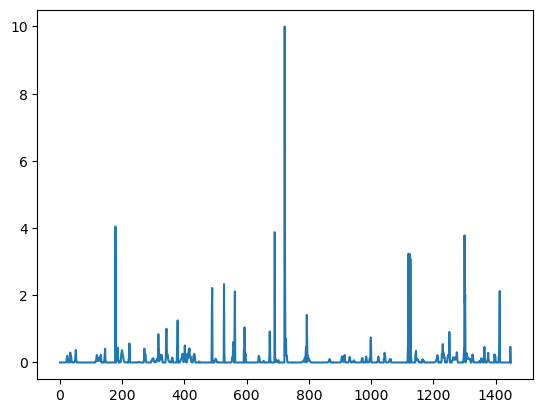

In [25]:
plt.plot(df.odor)